In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
data = "load_data_here"

/Users/alimahdi/anaconda3/lib/python3.8/site-packages/scipy/io/matlab/mio.py:224: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [4]:
zin_EIS = data['Zin_EIS']
zout_EIS = data['Zout_EIS']

In [5]:
# For EIS
# Define frequency
w = np.zeros(zout_EIS.shape[1])
num = -1
for i in range(zout_EIS.shape[1]):
    w[i] = 2*np.pi*10**(num)
    num += 0.1
EDC = 0; # EIS DC component of cell potential in V

In [6]:
E0 = 0 # standard potential of redox couple in V
n=1 # number of electrons per rxn
F=96400 # charge of electron in C/mol
R=8.31 # gas constant in J/mol/K
T=298 # temperature in K
A=1 # area in cm^2

In [9]:
# Variables that could be fit related to redox part are below:
# IGNORE AT FIRST, LEAVE UNCHANGED
D=1e-5 # diffusion constant in cm^2/s
ctotal=1e-6 # total concentration of redox species in mol/cm^3
Rct0 = 200 # charge-transfer resistance at E0 in ohms

# charge-transfer resistance at EDC for alpha=1/2
Rct = Rct0*(np.exp((EDC-E0)/(2*R*T/n/F))+np.exp(-(EDC-E0)/(2*R*T/n/F)))/2; 
# redox capacitance in F

Credox = (n**2*F**2/R/T)*A*(D/w)**0.5*ctotal*np.exp(-(EDC-E0)/(R*T/n/F))*(1+np.exp(-(EDC-E0)/(R*T/n/F)))**-2

In [10]:
#def redoximped(input_cd = 1e-6, input_ru = 50):
Cd = 1e-6
Ru = 50
#Cd = input_cd
#Ru = input_ru
# Compute Impedance and Admittance values, building step by step
Zin = Rct # in-phase impedance of charge transfer
Zout = 0 # out-of-phase impedance of charge transfer
Zin = Zin + 1/(w*Credox) # in-phase impedance of redox branch of circuit
Zout = 1/(w*Credox)  # out-of-phase impedance of redox branch of circuit
Yin = Zin / (Zin**2 + Zout**2)  # in-phase admittance of redox branch of circuit
Yout = Zout / (Zin**2 + Zout**2) # out-of-phase admittance of redox branch of circuit
Yin = Yin # in-phase admittance of redox and double-layer parallel branches of circuit
Yout = Yout + w*Cd # out-of-phase admittance of redox and double-layer parallel branches of circuit
Zin = Yin / (Yin**2 + Yout**2) # in-phase impedance of redox and double-layer parallel branches of circuit
Zout = Yout / (Yin**2 + Yout**2) # out-of-phase impedance of redox and double-layer parallel branches of circuit


# FINAL FUNCTIONS TO FIT - functions represents entire circuit
Zin = Zin + Ru # in-phase impedance of entire circuit
Zout = Zout # out-of-phase impedance of entire circuit
Yin = Zin / (Zin**2 + Zout**2)  # in-phase admittance of entire circuit
Yout = Zout / (Zin**2 + Zout**2) # out-of-phase admittance of entire of circuit


In [11]:
def redox(input_cd = 1e-6, input_ru = 50):
    Cd = 1.56330440e-06
    Ru = 9.43225990e+01
    # Compute Impedance and Admittance values, building step by step
    Zin = Rct # in-phase impedance of charge transfer
    Zout = 0 # out-of-phase impedance of charge transfer
    Zin = Zin + 1/(w*Credox) # in-phase impedance of redox branch of circuit
    Zout = 1/(w*Credox)  # out-of-phase impedance of redox branch of circuit
    Yin = Zin / (Zin**2 + Zout**2)  # in-phase admittance of redox branch of circuit
    Yout = Zout / (Zin**2 + Zout**2) # out-of-phase admittance of redox branch of circuit
    Yin = Yin # in-phase admittance of redox and double-layer parallel branches of circuit
    Yout = Yout + w*Cd # out-of-phase admittance of redox and double-layer parallel branches of circuit
    Zin = Yin / (Yin**2 + Yout**2) # in-phase impedance of redox and double-layer parallel branches of circuit
    Zout = Yout / (Yin**2 + Yout**2) # out-of-phase impedance of redox and double-layer parallel branches of circuit

    # FINAL FUNCTIONS TO FIT - functions represents entire circuit
    Zin = Zin + Ru # in-phase impedance of entire circuit
    Zout = Zout # out-of-phase impedance of entire circuit
    Yin = Zin / (Zin**2 + Zout**2)  # in-phase admittance of entire circuit
    Yout = Zout / (Zin**2 + Zout**2) # out-of-phase admittance of entire of circuit
    plt.plot(Zin, Zout)
    plt.show()

In [12]:
zin_EIS = zin_EIS.reshape(-1)
zout_EIS = zout_EIS.reshape(-1)

In [26]:
from scipy.optimize import curve_fit

In [255]:
def f(x, R1, R2, C):
    #out = R1 + (R2*1/((2*np.pi*x)*C))/(R2+(2*np.pi*x*C))
    #out = R1 + ((R2 * C * 2 * np.pi * x) / (R2 + (C * 2 * np.pi * x)) )
    out = R1 + (R2/((R2 * C * 2 * np.pi * x) + 1)) 
    return np.log10(out)

# R1 is equal to Re(Z) at the highest frequency point (Rs)
# R2 should roughly be diameter of semicircle (Rct)
# C is the apex of the circle
def fit(x,y, maxfev = 100000, label = None):
    popt, popc = curve_fit(f, x, y, maxfev = maxfev, p0 = [20,300,1e-9],bounds = ([0,0,0],[np.inf,np.inf,np.inf]))
    plt.loglog(x , y, label = 'Experimental')
    plt.loglog(x , f(x, popt[0],popt[1],popt[2]), label = 'Simulated')
    plt.xlabel('Frequency', fontsize = 16)
    plt.ylabel('Abs. Impedance', fontsize = 16)
    plt.legend()
    return popt, popc

In [230]:
z_abs = np.sqrt(real_Zin**2 + real_Zout**2)
y_data = np.log10(z_abs)

In [236]:
z_abs_real = np.sqrt(real_Zin**2 + real_Zout**2)
z_abs_sim = np.sqrt(sim_Zin**2 + sim_Zout**2)
y_data_sim = np.log10(z_abs_sim)

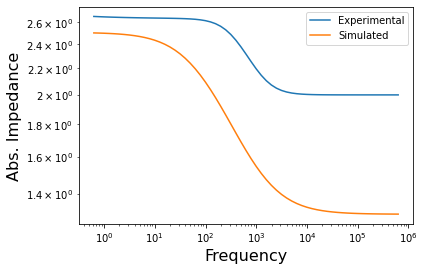

In [251]:
plt.loglog(w, y_data, label = 'Experimental')
#plt.loglog(w, y_data_sim, label = 'Simulated')
plt.loglog(w, f(w, 20, 300, 1e-5), label = 'Simulated')
plt.xlabel('Frequency', fontsize = 16)
plt.ylabel('Abs. Impedance', fontsize = 16)
plt.legend()
plt.show()

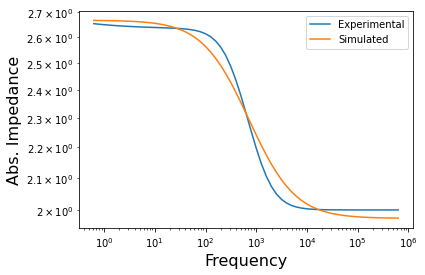

In [256]:
result, _ = fit(w, y_data)
#print(result)